In [1]:
# 加载 yolov3模型（基于COCO dataset 预训练）进行目标检测
# 基于 https://github.com/experiencor/keras-yolo3
import numpy as np
from numpy import expand_dims
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from matplotlib import pyplot
from matplotlib.patches import Rectangle

class BoundBox:
	def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
		self.xmin = xmin
		self.ymin = ymin
		self.xmax = xmax
		self.ymax = ymax
		self.objness = objness
		self.classes = classes
		self.label = -1
		self.score = -1

	def get_label(self):
		if self.label == -1:
			self.label = np.argmax(self.classes)

		return self.label

	def get_score(self):
		if self.score == -1:
			self.score = self.classes[self.get_label()]

		return self.score

def _sigmoid(x):
	return 1. / (1. + np.exp(-x))

def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
	grid_h, grid_w = netout.shape[:2]
	nb_box = 3
	netout = netout.reshape((grid_h, grid_w, nb_box, -1))
	nb_class = netout.shape[-1] - 5
	boxes = []
	netout[..., :2]  = _sigmoid(netout[..., :2])
	netout[..., 4:]  = _sigmoid(netout[..., 4:])
	netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
	netout[..., 5:] *= netout[..., 5:] > obj_thresh

	for i in range(grid_h*grid_w):
		row = i / grid_w
		col = i % grid_w
		for b in range(nb_box):
			# 第5个元素为目标在该类下的名称
			objectness = netout[int(row)][int(col)][b][4]
			if(objectness.all() <= obj_thresh): continue
			# 前四个元素是 x, y, w, 和 h
			x, y, w, h = netout[int(row)][int(col)][b][:4]
			x = (col + x) / grid_w # 中心位置, unit: image width
			y = (row + y) / grid_h # 中心位置, unit: image height
			w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
			h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
			# 最后一个元素是该类下的概率
			classes = netout[int(row)][col][b][5:]
			box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
			boxes.append(box)
	return boxes

def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
	new_w, new_h = net_w, net_h
	new_boxes=[]
	for i in range(len(boxes)):
		x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
		y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
		boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
		boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
		boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
		boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

def _interval_overlap(interval_a, interval_b):
	x1, x2 = interval_a
	x3, x4 = interval_b
	if x3 < x1:
		if x4 < x1:
			return 0
		else:
			return min(x2,x4) - x1
	else:
		if x2 < x3:
			 return 0
		else:
			return min(x2,x4) - x3

def bbox_iou(box1, box2):
	intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
	intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
	intersect = intersect_w * intersect_h
	w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
	w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
	union = w1*h1 + w2*h2 - intersect
	return float(intersect) / union

def do_nms(boxes, nms_thresh):
	if len(boxes) > 0:
		nb_class = len(boxes[0].classes)
	else:
		return
	for c in range(nb_class):
		sorted_indices = np.argsort([-box.classes[c] for box in boxes])
		for i in range(len(sorted_indices)):
			index_i = sorted_indices[i]
			if boxes[index_i].classes[c] == 0: continue
			for j in range(i+1, len(sorted_indices)):
				index_j = sorted_indices[j]
				if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
					boxes[index_j].classes[c] = 0

# 加载图像
def load_image_pixels(filename, shape):
	# 加载图片并得到它的大小
	image = load_img(filename)
	width, height = image.size
	# 用目标大小加载图片
	image = load_img(filename, target_size=shape)
	# 转换类型为numpy array
	image = img_to_array(image)
	# 规范像素值为[0, 1]
	image = image.astype('float32')
	image /= 255.0
	# 增加一个维度，这样我们就有一个样本
	image = expand_dims(image, 0)
	return image, width, height

# 获得阈值以上的所有结果
def get_boxes(boxes, labels, thresh):
	v_boxes, v_labels, v_scores = list(), list(), list()
	# 枚举所有边界框
	for box in boxes:
		# 枚举所有可能的标签
		for i in range(len(labels)):
			# 检查此标签的阈值是否足够高
			if box.classes[i] > thresh:
				v_boxes.append(box)
				v_labels.append(labels[i])
				v_scores.append(box.classes[i]*100)
				# 不要break，许多标签可能触发一个边界框
	return v_boxes, v_labels, v_scores

# 画出所有结果
def draw_boxes(filename, v_boxes, v_labels, v_scores):
	# 加载图片
	data = pyplot.imread(filename)
	# 显示图片
	pyplot.imshow(data)
	# 获取绘制框的内容
	ax = pyplot.gca()
	# 画出每个边界框
	for i in range(len(v_boxes)):
		box = v_boxes[i]
		# 得到坐标
		y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
		# 计算盒子的宽度和高度
		width, height = x2 - x1, y2 - y1
		# 创建形状
		rect = Rectangle((x1, y1), width, height, fill=False, color='red')
		# 画出边界框
		ax.add_patch(rect)
		# 在左上角绘制标签和分数
		pyplot.text(x1, y1, "{} {:.0f}%".format(v_labels[i], v_scores[i]), bbox=dict(facecolor='white', alpha=0.5))
	# 展示图
	pyplot.show()

# 加载 yolov3 模型，使用时更改文件目录
model = load_model('/content/drive/My Drive/Colab Notebooks/yolov3_model.h5')

#输入图片路径，得到检测结果
def detection_of_image(photo_filename):
		# 为模型定义期望的输入形状
		input_w, input_h = 416, 416
		# 定义锚
		anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
		# 定义检测到的对象的概率阈值
		class_threshold = 0.6
		# 定义标签
		labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
			"boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
			"bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
			"backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
			"sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
			"tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
			"apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
			"chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
			"remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
			"book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]
		# 加载和准备图像
		image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
    # 做出预测
		yhat = model.predict(image)
    # 总结数组列表的形状
		print([a.shape for a in yhat])
		boxes = list()
		for i in range(len(yhat)):   
      # 解码网络的输出
			boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
    # 校正图像形状的边框的大小
		correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
    # 抑制没有大于阈值的边界框
		do_nms(boxes, 0.5)
    # 获取检测到的对象的详细信息
		v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
    # 总结结果
		for i in range(len(v_boxes)):
			print(v_labels[i], v_scores[i])
    # 绘图展示结果
		draw_boxes(photo_filename, v_boxes, v_labels, v_scores)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
person 97.12033271789551
person 96.64698243141174
person 99.07765984535217
person 99.4299590587616
person 99.88399744033813
person 99.87377524375916
person 79.83834147453308
person 84.11487340927124
person 77.83792018890381
person 99.84931349754333
person 99.3066132068634
person 99.33435320854187


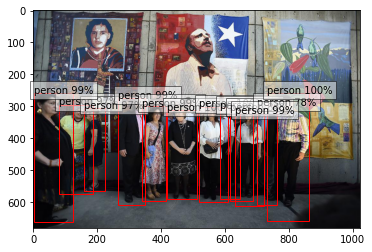

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
person 85.85758805274963
person 99.1373062133789
person 97.44342565536499
person 80.29826283454895
person 87.83065676689148
person 73.28205108642578
person 99.6454656124115
person 98.78005385398865
person 91.56492948532104
tie 60.577404499053955


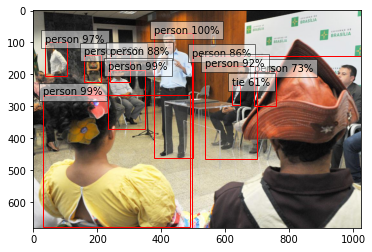

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
person 99.07557368278503
cell phone 73.38518500328064


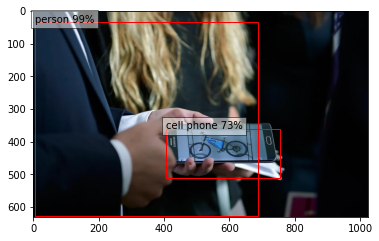

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
person 98.05126190185547
person 80.05433082580566
person 99.0183413028717
book 71.12618684768677
person 80.12490272521973


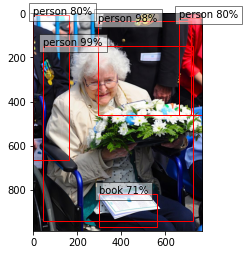

In [2]:
import os
# 加载图片
folder = "/content/drive/My Drive/test_image/"
list_of_test_data = [f for f in os.listdir(folder) if f.endswith('.jpg')]
for image_path in list_of_test_data:
    photo_filename = folder + image_path
    detection_of_image(photo_filename)